# Traffic Sign or Not Traffic Sign
Reference: https://github.com/mzaradzki/neuralnets/tree/master/vgg_faces_keras

Since we're brute-forcing some "art-sticker" to mislead the classifier, we may want to use AWS EC2 instance with GPU.
Here's how to install Caffe: https://github.com/BVLC/caffe/wiki/Caffe-installing-script-for-ubuntu-16.04---support-Cuda-8

In [1]:
import shutil
import requests
import tempfile
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.mpl_style', 'default')
%matplotlib inline

caffe_root = '/opt/caffe/'

import sys
sys.path.insert(0, caffe_root + 'python')

import caffe
plt.rcParams['figure.figsize'] = (4, 4)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

/opt/conda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2885: FutureWarning: 
mpl_style had been deprecated and will be removed in a future version.
Use `matplotlib.pyplot.style.use` instead.

  exec(code_obj, self.user_global_ns, self.user_ns)


In [2]:
# Load the labels (so we know whether 242 means 'adorable puppy' or 'garbage can')
# n06794110 street sign
imagenet_labels_filename = caffe_root + '/data/ilsvrc12/synset_words.txt'
try:
    labels = np.loadtxt(imagenet_labels_filename, str, delimiter='\t')
except:
    !/opt/caffe/data/ilsvrc12/get_ilsvrc_aux.sh
    labels = np.loadtxt(imagenet_labels_filename, str, delimiter='\t')

In [3]:
# Set Caffe to CPU mode because who even knows how to set up a GPU (not me)
caffe.set_mode_cpu()

# Load our model! trained by the GOOGLES! <3
def load_model():
    BATCH_SIZE = 1
    net = caffe.Net('/opt/caffe/models/bvlc_googlenet/deploy.prototxt',
                    '/models/bvlc_googlenet.caffemodel',
                    caffe.TEST)
    # change batch size to 1 for faster processing
    # this just means that we're only processing one image at a time instead of like 50
    shape = list(net.blobs['data'].data.shape)
    shape[0] = BATCH_SIZE
    net.blobs['data'].reshape(*shape)
    net.blobs['prob'].reshape(BATCH_SIZE, )
    net.reshape() 
    return net
net = load_model()
# Caffe comes with a handy transformer pipeline so that
# we can make our images into the format it needs! Yay!
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2,0,1))
transformer.set_raw_scale('data', 255)  # the reference model operates on images in [0,255] range instead of [0,1]
transformer.set_channel_swap('data', (2,1,0))  # the reference model has channels in BGR order instead of RGB

In [4]:
def get_png_image(url):
    fd, path = tempfile.mkstemp()
    tmpfile = os.fdopen(fd, "wb")
    response = requests.get(url, stream=True)
    shutil.copyfileobj(response.raw, tmpfile)   # potential vulnerability in this function, but who cares?
    if 'png' in url:
        !mv {path} {path}.png
    else:
        !convert {path} {path}.png
    path = path + ".png"
    return transformer.preprocess('data', caffe.io.load_image(path))

In [5]:
art_sticker_05ft_data = transformer.preprocess('data', caffe.io.load_image('./experimental_attack_images/art-sticker-05ft_0deg.jpg'))

In [6]:
print art_sticker_05ft_data.shape

(3, 224, 224)


In [7]:
net.blobs['data'].data[...] = art_sticker_05ft_data
out = net.forward()
pred_class = out['prob'][0].argmax()
print("Predicted class is #{}.".format(pred_class))

Predicted class is #919.


/opt/conda/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'monospace'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


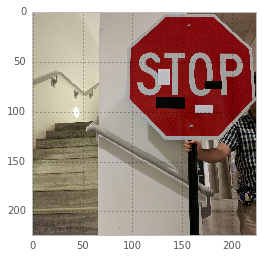

In [8]:
plt.imshow(transformer.deprocess('data', net.blobs['data'].data[0]))

In [9]:
print labels[pred_class]

n06794110 street sign


So, we can't cheat ImageNet with art sticks that worked in Evtimov et al. (2017).
Let's try something real.  Image taken from https://www.upbeat.com/Images/blog/parkinglot1-09052013.jpg

In [10]:
def display(data):
    plt.imshow(transformer.deprocess('data', data))

def get_label_name(num):
    options = labels[num].split(',')
    # remove the tag
    options[0] = ' '.join(options[0].split(' ')[1:])
    return ','.join(options[:2])
    
def predict(data, n_preds=6, display_output=True):
    net.blobs['data'].data[...] = data
    if display_output:
        display(data)
    prob = net.forward()['prob']
    probs = prob[0]
    prediction = probs.argmax()
    top_k = probs.argsort()[::-1]
    for pred in top_k[:n_preds]:
        percent = round(probs[pred] * 100, 2)
        # display it compactly if we're displaying more than the top prediction
        pred_formatted = "%03d" % pred
        if n_preds == 1:
            format_string = "label: {cls} ({label})\ncertainty: {certainty}%"
        else:
            format_string = "label: {cls} ({label}), certainty: {certainty}%"
        if display_output:
            print format_string.format(
                cls=pred_formatted, label=get_label_name(pred), certainty=percent)
    return prob

In [11]:
# Convert PIL image to Caffe image
from PIL import Image
def conv_pil(im):
    img = np.asarray(im).astype(np.float32) / 255.
    if img.ndim == 2:
        img = img[:, :, np.newaxis]
        img = np.tile(img, (1, 1, 3))
    elif img.shape[2] == 4:
        img = img[:, :, :3]
    return img

label: 919 (street sign), certainty: 96.87%
label: 637 (mailbox, letter box), certainty: 0.85%
label: 781 (scoreboard), certainty: 0.53%
label: 920 (traffic light, traffic signal), certainty: 0.36%
label: 787 (shield, buckler), certainty: 0.14%
label: 489 (chainlink fence), certainty: 0.13%


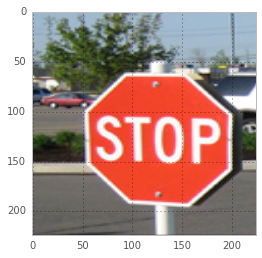

In [12]:
stop_im = Image.open('./stopsign-1.png')
stop_im = stop_im.crop((40, 30, 150, 180))   # 110 x 150
stop_caffe = conv_pil(stop_im)
stop_data = transformer.preprocess('data', stop_caffe)
probs = predict(stop_data)

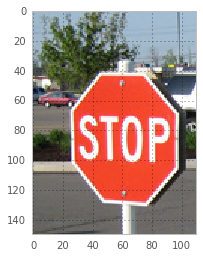

In [13]:
plt.imshow(stop_im)                                    # X: 25-90, Y: 40-125

# Experiment 1
Generate random stickers of black, white, and gray colors.

Result: Failed after certain iterations.

In [36]:
# Prepare "art stickers"
three_colors = [(240,245,245,0), (20,20,20,0), (60, 60, 60, 0)]   # Black, white, gray stickers
widths = range(10, 11)
heights = range(10, 11)
num_stickers = 10

color_pallettes = [
    (0, 152, 116, 0),   # emerald
    (221, 65, 36, 0),   # tangerine tango
    (214, 80, 118, 0), # honeysuckle
    (68, 184, 172, 0), # turquoise
    (239, 192, 80, 0), # mimosa
    (91, 94, 166, 0),    # blue izis
    (155, 35, 53, 0),    # chilli pepper
    (223, 207, 190, 0), # sand dollar
    (85, 180, 176, 0),   # blue turquoise
    (225, 93, 68, 0),    # tigerlily
    (127, 205, 205, 0), # aqua sky
    (188, 36, 60, 0),     # true red
    (195, 68, 122, 0),  # fuchsia rose
    (152, 180, 212, 0), # cerulean blue
]

def paste_stickers(im, stickers, colors):
    newim = im.copy()
    draw = ImageDraw.Draw(newim)
    for j in range(stickers):
        w = choice(widths)
        h = choice(heights)
        x = randrange(25, 91-w)
        y = randrange(40, 126-h)
        color = choice(colors)
        draw.rectangle((x, y, x+w, y+h), fill=color)
    del draw
    return newim

In [37]:
def get_prob_label(prob):
    probs = prob[0]
    top_k = probs.argsort()[::-1]
    return top_k[0]

def print_topk(prob):
    probs = prob[0]
    top_k = probs.argsort()[::-1]
    for pred in top_k[:6]:
        percent = round(probs[pred] * 100, 2)
        pred_formatted = "%03d" % pred
        format_string = "label: {cls} ({label}), certainty: {certainty}%"
        print format_string.format(cls=pred_formatted, label=get_label_name(pred), certainty=percent)

In [38]:
from PIL import ImageDraw
from random import randrange, choice
for i in range(1000):
    print i,
    newim = paste_stickers(stop_im, num_stickers, three_colors)
    caffe_im = conv_pil(newim)
    data = transformer.preprocess('data', caffe_im)
    prob = predict(data, 1, False)
    if get_prob_label(prob) != 919:   # not a street sign
        print '\nHit at iteration %d' % i
        print_topk(prob)
        break
    del data
    del caffe_im
    del newim
display(data)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

KeyboardInterrupt: 

# Experiment 2
Use color pallettes here:
https://i.pinimg.com/736x/ae/b0/01/aeb001b62989e505f22ebe0d6e0780b5--colour-hex-codes-colour-palettes.jpg

In [39]:
num_trials = 1000
for i in range(num_trials):
    newim = paste_stickers(stop_im, num_stickers, color_pallettes)
    caffe_im = conv_pil(newim)
    data = transformer.preprocess('data', caffe_im)
    prob = predict(data, 1, False)
    if get_prob_label(prob) != 919:   # not a street sign
        print 'Hit at iteration %d' % i
        print_topk(prob)
        display(data)
        break
    del data
    del caffe_im
    del newim